In [3]:
%matplotlib inline
# from __future__ import absolute_import, division, print_function
from numpy import array
import tensorflow as tf
import numpy as np
import librosa
from estnoise_ms import *

import glob
import matplotlib.pyplot as plt
import os
import librosa.display
tf.enable_eager_execution()
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import psutil
import time
import resource
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

def humanbytes(B):
   'Return the given bytes as a human friendly KB, MB, GB, or TB string'
   B = float(B)
   KB = float(1024)
   MB = float(KB ** 2) # 1,048,576
   GB = float(KB ** 3) # 1,073,741,824
   TB = float(KB ** 4) # 1,099,511,627,776

   if B < KB:
      return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
   elif KB <= B < MB:
      return '{0:.2f} KB'.format(B/KB)
   elif MB <= B < GB:
      return '{0:.2f} MB'.format(B/MB)
   elif GB <= B < TB:
      return '{0:.2f} GB'.format(B/GB)
   elif TB <= B:
      return '{0:.2f} TB'.format(B/TB)


In [2]:
def loss(model, y_pred):
    sigma = estnoisem(y_pred,0.032)
    y_= model(y_pred**2)
    
    n = tf.random_normal(tf.shape(y_),mean=0.0)
    yn= y_ + n
    yep = sigma*tf.multiply(n,(model(tf.convert_to_tensor(yn)) - model(tf.convert_to_tensor(y_))))

    A = tf.size(y_pred,out_type=tf.float32)
    
    l = tf.abs(tf.reduce_sum(tf.pow(y_pred-y_,2)-sigma + yep)/A)
#     print(l)

    return l,sigma



In [3]:
def mseloss(model, y_pred, y_true):
    enhout = lstm_model(y_pred)
    #mean squared error
    A = tf.size(enhout,out_type=tf.float32)
    l = tf.abs((tf.reduce_sum(tf.pow(enhout-y_true,2)))/A)
    return l


In [4]:
n_in=10
n_fft=512
freq=257
batchsize=30
num_inputs = 40000
timesteps=20
maxshape=300
epochs=1
reruns=20
samplerate=8000

lstm_model = tf.keras.Sequential([
    tf.keras.layers.CuDNNLSTM(freq, input_shape=(None,freq),return_sequences=True)
    ])

lstm_model=tf.keras.Sequential()
lstm_model.add( tf.keras.layers.CuDNNLSTM(freq, input_shape=(None,freq)))
lstm_model.add(tf.keras.layers.RepeatVector(timesteps))
lstm_model.add( tf.keras.layers.CuDNNLSTM(freq, return_sequences=True))
lstm_model.add(tf.keras.layers.TimeDistributed(Dense(freq)))


In [5]:
x=tf.keras.layers.Input(shape=(None,freq))
x1=tf.keras.layers.CuDNNLSTM(500, input_shape=(None,freq))(x)
x2=tf.keras.layers.RepeatVector(timesteps)(x1)
x3=tf.keras.layers.CuDNNLSTM(500,return_sequences=True)(x2)
x4=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(freq))(x3)
x5=tf.keras.layers.multiply([x,x4])
lstm_model=tf.keras.models.Model(inputs=[x],outputs=[x5])

In [5]:
# 
optimizer = tf.train.AdamOptimizer()
loss_history = []
sigma_history = []
summary_writer = tf.contrib.summary.create_file_writer('logs8', flush_millis=10000)
summary_writer.set_as_default()
global_step = tf.train.get_or_create_global_step()

def log_loss(loss):
    with tf.contrib.summary.always_record_summaries():
        tf.contrib.summary.scalar('loss', loss)
# lstm_model.summary()

In [7]:
####MMMMMMMEEEEEEEAAAAAAAAAAANNNNNNNNNN MMMMMMMMMMMMMSSSSSSSSSSSSSSEEEEEEEEEEEEEEEEEEE
###
###

for i0 in range(reruns):
    print("Epoch......",i0)
    for filename in glob.glob('../noisyreverb_testset_wav/*.wav'):
        cleanfile = '../clean_testset_wav/'+filename[27:]
        #         print(cleanfile)
        sp1, sr = librosa.load(filename,sr=samplerate,mono=True)
        clsp1, sr = librosa.load(cleanfile,sr=samplerate,mono=True)


        D = np.abs(librosa.stft(sp1,n_fft=n_fft))

        if np.size(D,1) < maxshape:
            shapetrans = np.size(D,1)
        else:
            shapetrans = maxshape

        D = D[:,:shapetrans].transpose()
        #         print(np.shape(D))
        rr = shapetrans % timesteps
        D=D[rr:,:]
        D=np.reshape(D,((int(shapetrans/timesteps),timesteps,int((n_fft/2)+1))))


        C = np.abs(librosa.stft(clsp1,n_fft=n_fft))
        C = C[:,:shapetrans].transpose()
        C=C[rr:,:]
        C=np.reshape(C,((int(shapetrans/timesteps),timesteps,int((n_fft/2)+1))))

        #         print(D.shape)
        #     D=D.reshape(batchsize,int(maxshape/batchsize),timesteps,(n_fft/2)+1)
        for i2 in range(int(shapetrans/timesteps)):
            for i1 in range(epochs):
                with tf.GradientTape() as tape:
                    enhout = lstm_model(D[np.newaxis,i2,:,:], training=True)
                    loss_value = mseloss(lstm_model,D[np.newaxis,i2,:,:],C[np.newaxis,i2,:,:])
        #             if i%10 == 0:    
                   # print("Loss at step {:03d}: {:.3f}".format(i, loss(lstm_model, D[np.newaxis,i1,:,:])))
                global_step.assign_add(1)
                log_loss(loss_value)
                loss_history.append(loss_value.numpy())
        #                 sigma_history.append(sigma)
                grads = tape.gradient(loss_value, lstm_model.variables)
                optimizer.apply_gradients(zip(grads, lstm_model.variables),
                                        global_step=tf.train.get_or_create_global_step())
    print("...Loss...", loss_value.numpy(),"\n")
    lstm_model_json = lstm_model.to_json()
    with open("trained/lstm_model_8k_mask.json", "w") as json_file:
        json_file.write(lstm_model_json)
    lstm_model.save_weights("trained/lstm_model_8k_mask.h5")
    print("Saved model to disk \n")

Epoch...... 0
...Loss... 0.43209165 

Saved model to disk 

Epoch...... 1
...Loss... 0.4197074 

Saved model to disk 

Epoch...... 2
...Loss... 0.42261463 

Saved model to disk 

Epoch...... 3
...Loss... 0.42982382 

Saved model to disk 

Epoch...... 4
...Loss... 0.4269495 

Saved model to disk 

Epoch...... 5
...Loss... 0.4188611 

Saved model to disk 

Epoch...... 6
...Loss... 0.41455877 

Saved model to disk 

Epoch...... 7
...Loss... 0.4171198 

Saved model to disk 

Epoch...... 8
...Loss... 0.41719443 

Saved model to disk 

Epoch...... 9
...Loss... 0.41762188 

Saved model to disk 

Epoch...... 10
...Loss... 0.41339958 

Saved model to disk 

Epoch...... 11
...Loss... 0.43703914 

Saved model to disk 

Epoch...... 12
...Loss... 0.42210773 

Saved model to disk 

Epoch...... 13
...Loss... 0.42262068 

Saved model to disk 

Epoch...... 14
...Loss... 0.4281929 

Saved model to disk 

Epoch...... 15
...Loss... 0.39348903 

Saved model to disk 

Epoch...... 16
...Loss... 0.4195942 

S

# from tf.keras.models import model_from_json
lstm_model_json = lstm_model.to_json()
with open("trained/lstm_model.json", "w") as json_file:
    json_file.write(lstm_model_json)
lstm_model.save_weights("trained/lstm_model.h5")
print("Saved model to disk")

In [5]:
json_file = open("trained/lstm_model_8k_mask.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
lstm_model = tf.keras.models.model_from_json(loaded_model_json)
lstm_model.load_weights("trained/lstm_model_8k_mask.h5")

Instructions for updating:
Colocations handled automatically by placer.


The below cell trains the LSTM model using an Adamoptimizer and takes "timesteps" number of 

In [8]:
# with tf.Graph().as_default():

#     with tf.Session() as sess:
#         writer = tf.summary.FileWriter("./tmp/log/...", sess.graph)
#         tf.keras.backend.set_session(sess)
start_time = time.time()
loss_history=[]   
for i0 in range(1):
    for filename in glob.glob('../testmixture/*.wav'):
        print(filename)
        sp1, sr = librosa.load(filename,sr=samplerate,mono=True)
#         sp1 = sp1[:num_inputs]
        D = np.abs(librosa.stft(sp1,n_fft=n_fft))

        if np.size(D,1) < maxshape:
            shapetrans = np.size(D,1)
        else:
            shapetrans = maxshape

        D = D[:,:shapetrans].transpose()
        #         print(np.shape(D))
        rr = shapetrans % timesteps
        D=D[rr:,:]
        D=np.reshape(D,((int(shapetrans/timesteps),timesteps,int((n_fft/2)+1))))
    #     print(D.shape)
    #     A = np.split(D,10)
        D1=D
#         print(D.shape)
    #     D=D.reshape(batchsize,int(maxshape/batchsize),timesteps,(n_fft/2)+1)
        for i2 in range(int(shapetrans/timesteps)):
            for i1 in range(epochs):
                with tf.GradientTape() as tape:
                    enhout = lstm_model(D[np.newaxis,i2,:,:], training=True)
                    loss_value,sigma = loss(lstm_model,D[np.newaxis,i2,:,:])
    #             if i%10 == 0:    
                   # print("Loss at step {:03d}: {:.3f}".format(i, loss(lstm_model, D[np.newaxis,i1,:,:])))
                global_step.assign_add(1)
                log_loss(loss_value)
                loss_history.append(loss_value.numpy())
                sigma_history.append(sigma)
                grads = tape.gradient(loss_value, lstm_model.variables)
                optimizer.apply_gradients(zip(grads, lstm_model.variables),
                                        global_step=tf.train.get_or_create_global_step())
                break;
total_time = time.time() - start_time
print("\n \n total time is: %s sec", total_time)

process = psutil.Process(os.getpid())
print ('RAM uses',humanbytes(process.memory_info().rss))
print ('VM uses',humanbytes(process.memory_info().vms))
#print('Memory taken..',size(process.memory_info().rss))
# print('swap memory', psutil.swap_memory())
# print('b...',process.memory_info().rss)
print('cpu_percent:-',psutil.cpu_percent(interval=None))


../testmixture/p257_169.wav
../testmixture/p257_050.wav
../testmixture/p257_108.wav
../testmixture/p257_171.wav
../testmixture/p257_049.wav
../testmixture/p257_110.wav
../testmixture/p257_109.wav
../testmixture/p257_170.wav
../testmixture/p257_048.wav

 
 total time is: %s sec 7.96429920197
RAM uses 1.98 GB
VM uses 33.93 GB
cpu_percent:- 1.1


NameError: name 'ppp' is not defined

In [19]:
# filename = "../testmixture/p257_171.wav"
filename = "../DATASET/SNR 10db 16k white noise/noisy_white_stereo_16k_0002.wav"
sp1, sr = librosa.load(filename,sr=samplerate,mono=True)
#         sp1 = sp1[:num_inputs]
D = np.abs(librosa.stft(sp1,n_fft=n_fft))
P = np.angle(librosa.stft(sp1,n_fft=n_fft))
#     sp = sp1.reshape(num_inputs/n_in,n_in)
if np.size(D,1) < maxshape:
    shapetrans = np.size(D,1)
else:
    shapetrans = maxshape

D = D[:,:shapetrans].transpose()
P = P[:,:shapetrans].transpose()
#         print(np.shape(D))
rr = shapetrans % timesteps
D=D[rr:,:]
P=P[rr:,:]

D1=D
D=np.reshape(D,((int(shapetrans/timesteps),timesteps,int((n_fft/2)+1))))

Ax = np.shape(D)

outsig = np.empty([0,int((n_fft/2)+1)])
outmask = np.empty([0,int((n_fft/2)+1)])
for i2 in range(int(shapetrans/timesteps)):
    for i1 in range(1):
        with tf.GradientTape() as tape:
#             print(np.shape(D[np.newaxis,i2,:,:]))
            enhout = lstm_model(D[np.newaxis,i2,:,:], training=True)
            outmask = np.append(outmask,enhout[0,:,:],axis=0)
            enhout = enhout*D[np.newaxis,i2,:,:]
# #             print('enhout----shape is..', np.shape(enhout))
#             print('outsig----shape is..', np.shape(outsig))
            outsig = np.append(outsig, enhout[0,:,:],axis=0)

(6, 20, 257)


Text(0,0.5,'SURE-Loss')

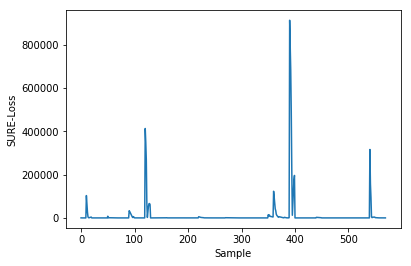

In [59]:
print(Ax)
plt.plot(loss_history)
plt.xlabel('Sample')
plt.ylabel('SURE-Loss')

In [ ]:
os.system("./p563 out.wav -out out.txt ")
text_file = open('out.txt','r')
# loss = 5.000-float(text_file.read())
# os.system("rm out.txt") 


<Figure size 432x288 with 0 Axes>

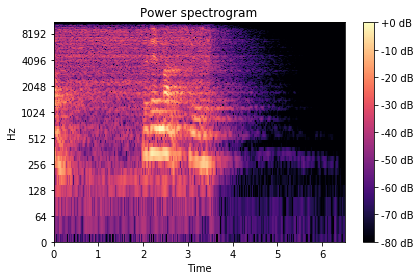

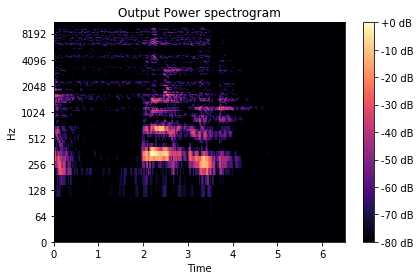

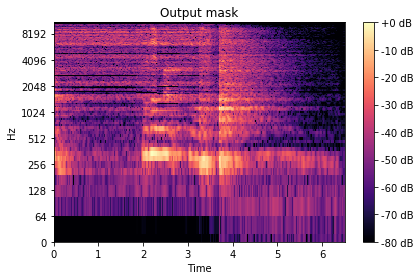

<Figure size 432x288 with 0 Axes>

In [20]:
librosa.display.specshow(librosa.amplitude_to_db(D1.transpose(),ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(outsig.transpose(),ref=np.max),y_axis='log', x_axis='time')
plt.title('Output Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(outmask.transpose(),ref=np.max),y_axis='log', x_axis='time')
plt.title('Output mask')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.figure()



<Figure size 432x288 with 0 Axes>

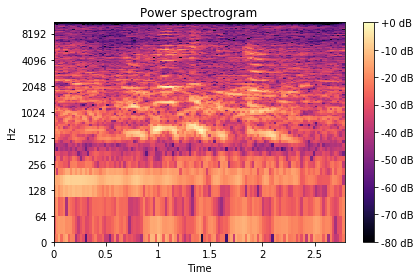

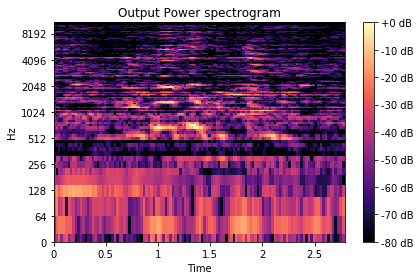

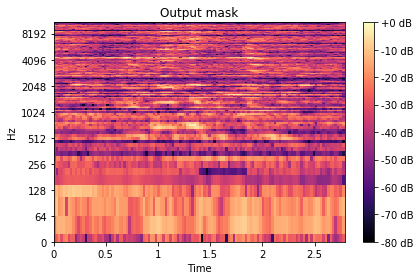

<Figure size 432x288 with 0 Axes>

In [64]:
librosa.display.specshow(librosa.amplitude_to_db(D1.transpose(),ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(outsig.transpose(),ref=np.max),y_axis='log', x_axis='time')
plt.title('Output Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(outmask.transpose(),ref=np.max),y_axis='log', x_axis='time')
plt.title('Output mask')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.figure()


(15232,)
(16395,)


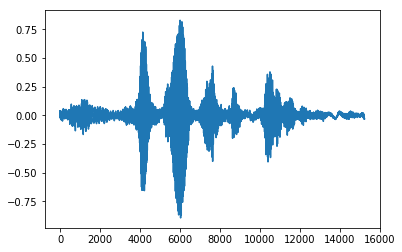

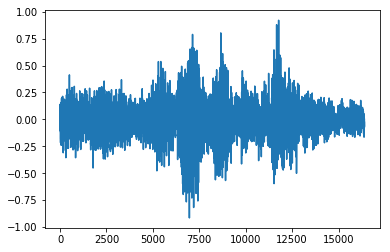

In [105]:

speechout = librosa.istft(np.multiply(outsig.transpose(),np.exp(1j*P.transpose())))
plt.figure()
plt.plot(2*speechout)
plt.figure()
plt.plot(sp1)
print(np.shape(speechout))
print(np.shape(sp1))

In [71]:
librosa.output.write_wav('out.wav', speechout, sr)

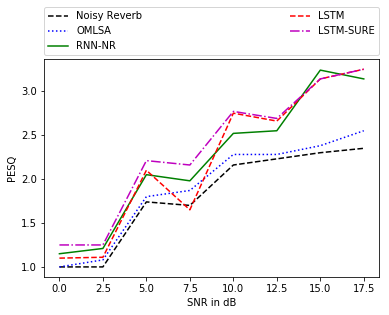

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
t = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
noisyreverb = [1.00, 1.00, 1.74, 1.70, 2.16,  2.23, 2.30, 2.35 ]
OMLSA = [1.00, 1.08 ,1.80 , 1.87, 2.28, 2.28,  2.38, 2.55]
RNNNR = [1.15,1.21, 2.05, 1.98, 2.52, 2.55, 3.24, 3.14]
LSTM = [1.10, 1.11, 2.10, 1.65, 2.75, 2.66, 3.14, 3.25]
LSTMSURE=[1.25, 1.25, 2.21,2.16,2.77, 2.69, 3.14,3.25]
# red dashes, blue squares and green triangles
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(t, noisyreverb, 'k--', label='Noisy Reverb')
ax.plot(t, OMLSA, 'b:', label='OMLSA')
ax.plot(t, RNNNR, 'g', label='RNN-NR')
ax.plot(t, LSTM, 'r--', label='LSTM')
ax.plot(t, LSTMSURE, 'm-.', label='LSTM-SURE')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')
plt.xlabel('SNR in dB')
plt.ylabel('PESQ')
plt.show()

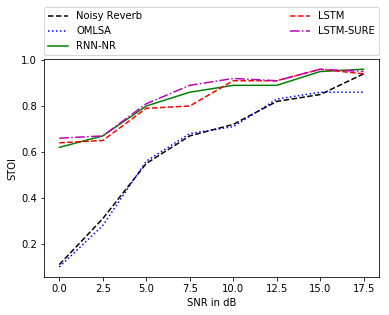

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
t = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
noisyreverb = [0.11, 0.31, 0.55, 0.67, 0.72, 0.82, 0.85, 0.94]
OMLSA = [0.10, 0.28, 0.56, 0.68, 0.71, 0.83, 0.86, 0.86]
RNNNR = [0.62, 0.67, 0.80, 0.86, 0.89, 0.89,0.95, 0.96]
LSTM = [0.64, 0.65, 0.79, 0.80, 0.91, 0.91, 0.96, 0.94]
LSTMSURE=[0.66, 0.67, 0.81, 0.89, 0.92, 0.91,0.96, 0.95]
# red dashes, blue squares and green triangles
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(t, noisyreverb, 'k--', label='Noisy Reverb')
ax.plot(t, OMLSA, 'b:', label='OMLSA')
ax.plot(t, RNNNR, 'g', label='RNN-NR')
ax.plot(t, LSTM, 'r--', label='LSTM')
ax.plot(t, LSTMSURE, 'm-.', label='LSTM-SURE')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')
plt.xlabel('SNR in dB')
plt.ylabel('STOI')
plt.show()

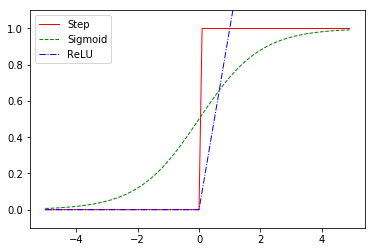

In [102]:
import numpy as np
import matplotlib.pylab as plt


def step(x):
    return np.array(x > 0, dtype=np.int)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

x = np.arange(-5.0, 5.0, 0.1)
y_step = step(x)
y_sigmoid = sigmoid(x)
y_relu = relu(x)

plt.plot(x, y_step, label='Step', color='r', lw=1, linestyle=None)
plt.plot(x, y_sigmoid, label='Sigmoid', color='g', lw=1, ls='--')
plt.plot(x, y_relu, label='ReLU', color='b', lw=1, linestyle='-.')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

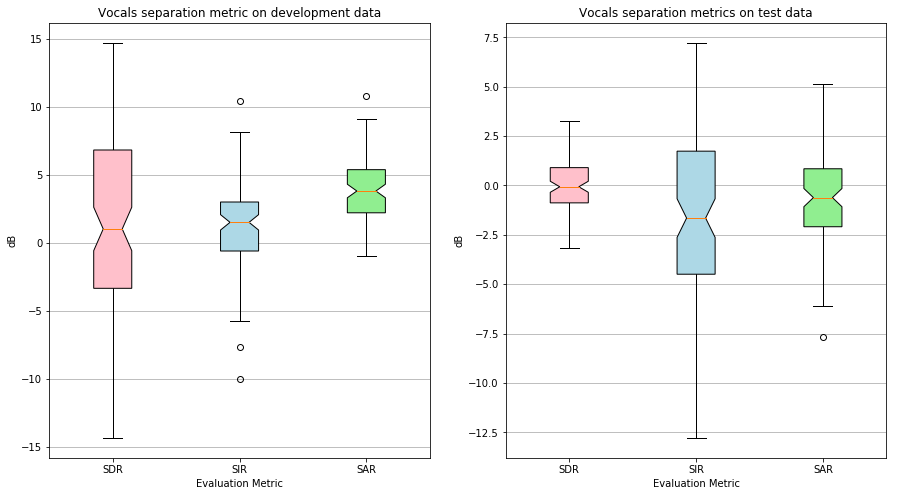

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Random test data
np.random.seed(123)
dev_voice_data = [np.random.normal(1.3, 5.6, 100),
            np.random.normal(1.3,3.5,100),
            np.random.normal(4,2.3,100)]
test_voice_data = [np.random.normal(0.2, 1.5, 100),
            np.random.normal(-2,4.1,100),
            np.random.normal(-1,2.4,100)]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# rectangular box plot
bplot1 = axes[0].boxplot(dev_voice_data,
                         notch=True,
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

# notch shape box plot
bplot2 = axes[1].boxplot(test_voice_data,
                         notch=True,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
#ax7.set_title('Multiple Samples with Different sizes')
# adding horizontal grid lines
axes[0].set_title('Vocals separation metric on development data')
axes[1].set_title('Vocals separation metrics on test data')
for ax in axes: 
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(dev_voice_data))], )
    ax.set_xlabel('Evaluation Metric')
    ax.set_ylabel('dB')

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(test_voice_data))],
         xticklabels=['SDR', 'SIR', 'SAR'])

plt.show()

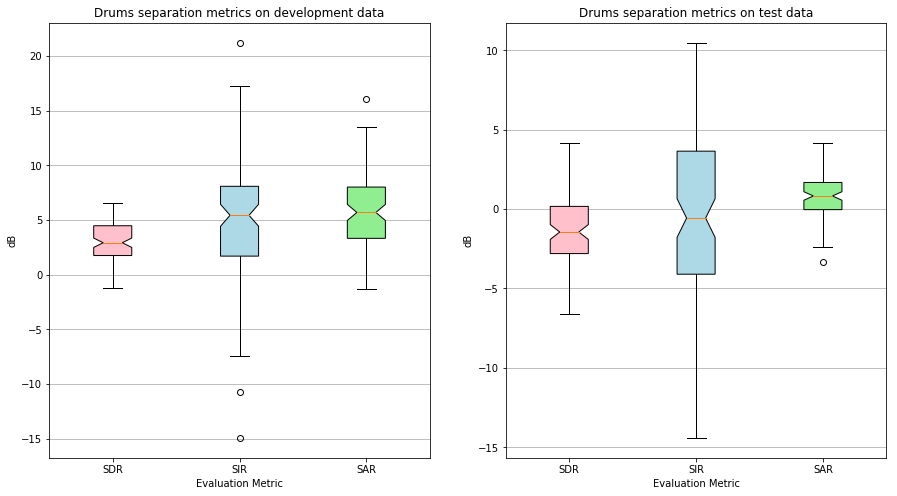

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Random test data
np.random.seed(123)
dev_voice_data = [np.random.normal(3, 1.5, 100),
            np.random.normal(5.1,6.2,100),
            np.random.normal(6,3.4,100)]
test_voice_data = [np.random.normal(-1, 2.5, 100),
            np.random.normal(-1,5.1,100),
            np.random.normal(0.6,1.4,100)]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# rectangular box plot
bplot1 = axes[0].boxplot(dev_voice_data,
                         notch=True,
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

# notch shape box plot
bplot2 = axes[1].boxplot(test_voice_data,
                         notch=True,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
#ax7.set_title('Multiple Samples with Different sizes')
# adding horizontal grid lines
axes[0].set_title('Drums separation metrics on development data')
axes[1].set_title('Drums separation metrics on test data')
for ax in axes: 
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(dev_voice_data))], )
    ax.set_xlabel('Evaluation Metric')
    ax.set_ylabel('dB')

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(test_voice_data))],
         xticklabels=['SDR', 'SIR', 'SAR'])

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
t = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
noisyreverb = [0.11, 0.31, 0.55, 0.67, 0.72, 0.82, 0.85, 0.94]
OMLSA = [0.10, 0.28, 0.56, 0.68, 0.71, 0.83, 0.86, 0.86]
RNNNR = [0.62, 0.67, 0.80, 0.86, 0.89, 0.89,0.95, 0.96]
LSTM = [0.64, 0.65, 0.79, 0.80, 0.91, 0.91, 0.96, 0.94]
LSTMSURE=[0.66, 0.67, 0.81, 0.89, 0.92, 0.91,0.96, 0.95]
# red dashes, blue squares and green triangles
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(t, noisyreverb, 'k--', label='Noisy Reverb')
ax.plot(t, OMLSA, 'b:', label='OMLSA')
ax.plot(t, RNNNR, 'g', label='RNN-NR')
ax.plot(t, LSTM, 'r--', label='LSTM')
ax.plot(t, LSTMSURE, 'm-.', label='LSTM-SURE')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')
plt.xlabel('SNR in dB')
plt.ylabel('STOI')
plt.show()